# PS 88 Project Part 2: Replication (Hall)

**General instructions:** these replications will be similar to labs, though with a bit less guidance than we would typically give. An advantage you have is that the answer you are supposed to get for most questions is in the paper.

When we say to "replicate" a table we don't mean you need to reproduce every bit of formatting. E.g., for regressions we just want you to verify that the coefficients match those reported in the table. For graphs, the output should look pretty similar, though again you don't need to make the formatting look exactly the same. 

On to the paper! The behavioral literature in American politics suggests that voters are not informed enough, and are too partisan, to be swing voters, while the institutional literature suggests that moderate candidates tend to perform better. We speak to this debate by examining the link between the ideology of congressional candidates and their electoral performance.

We will repoduce results from [this](https://www.andrewbenjaminhall.com/Hall_APSR.pdf) by Andrew Hall paper from the American Political Science Review. 


In [13]:
import pandas as pd
import numpy as np
from scipy import stats

import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt

## Part 1. Importing and Exploring

The replication data for this paper is stored in Stata format, so we read it in using the `pd.read_stata` function

In [14]:
#Bring in the main analysis dataset
full = pd.read_stata("primary_analysis.dta")
full

,state,dist,year,dem,redist1,redist2,vote_P0,cand_dwnom0,prim_total0,vote_P1,...,qual_D,qual_R,qual,winner_hall_snyder_score,wnom1,lag_wnom1,abs_lag_wnom,abs_dw_lag,winner_female,winner_share
0,AL,1,1984.0,1.0,98,103,0.454907,-0.073972,9258.0,0.545093,...,0,1,0.0,-0.034323,0.456358,0.231826,0.231826,0.067,0.0,0.681385
1,AL,1,2002.0,0.0,108,1000,0.375583,0.180372,104000.0,0.624417,...,1,0,0.0,0.138252,0.615196,NaN,NaN,NaN,0.0,0.578606
2,AL,2,1992.0,0.0,103,108,0.582899,0.128862,5000.0,0.417101,...,1,0,0.0,0.128862,0.547890,NaN,NaN,NaN,0.0,0.219780
3,AL,2,1992.0,1.0,103,108,0.428863,-0.312309,70849.0,0.571137,...,1,0,1.0,0.051086,0.547890,NaN,NaN,NaN,0.0,0.419912
4,AL,2,2008.0,0.0,108,1000,0.531126,0.225109,55000.0,0.468874,...,1,1,1.0,0.225109,0.082957,0.637359,0.637359,0.552,0.0,0.873016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,WV,1,1992.0,1.0,103,108,0.384997,-0.170781,81074.0,0.615003,...,0,0,0.0,-0.067638,-0.275327,NaN,NaN,NaN,0.0,0.626384
500,WV,1,2010.0,1.0,108,1000,0.440938,-0.067638,266793.0,0.559062,...,1,1,1.0,0.140244,0.349566,-0.569978,0.569978,0.286,0.0,0.075699
501,WV,2,1980.0,1.0,93,98,0.419902,-0.326184,11350.0,0.405550,...,1,0,1.0,-0.326184,0.228743,NaN,NaN,0.351,0.0,0.380235
502,WY,1,1994.0,0.0,51,1000,0.387491,0.184238,18899.0,0.247773,...,0,1,1.0,0.184238,0.772233,0.643263,0.643263,0.413,1.0,0.843743


In [15]:
full.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 503
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   state                        504 non-null    object 
 1   dist                         504 non-null    int16  
 2   year                         504 non-null    float64
 3   dem                          504 non-null    float32
 4   redist1                      504 non-null    int16  
 5   redist2                      504 non-null    int16  
 6   vote_P0                      504 non-null    float32
 7   cand_dwnom0                  504 non-null    float32
 8   prim_total0                  504 non-null    float64
 9   vote_P1                      504 non-null    float32
 10  cand_dwnom1                  504 non-null    float32
 11  fully_open_general           504 non-null    float32
 12  this_primary_open            504 non-null    float32
 13  this_primary_open_ot

In [16]:
full['year'].value_counts()

1992.0    70
1994.0    60
1996.0    39
1982.0    39
2002.0    36
1984.0    31
1988.0    29
1986.0    27
1980.0    25
2000.0    23
2006.0    23
1998.0    23
1990.0    21
2008.0    20
2004.0    20
2010.0    18
Name: year, dtype: int64

One of the key aspects of the paper is using campaign contributions to figure out which of the two main candidates in a primary is more extreme. The standard way to estimate the ideology of politicians is to look at their voting records. However, a drawback of this is that we can't use it to figure out the ideology of candidates for office who don't win. Since the key goal of the paper is to figure out which candidate is more extreme, we can't use voting records along as losing candidates typically don't hold office to generate a voting recored. A nice feature of campaign contributions is that we can estimate the ideology of losing candidates.

Still, it might be nice to check if the campaign contributions approach gives a similar estimate of ideology for those who do win. Figure 1 of the paper does this by comparing the "contributions-based ideology" measure in the `winner_hall_snyder_score` variable and the "Observed DW-NOMINATE Score" which is the ideology meausure based on voting (see <a href="https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)">here</a> for more detail) sored in the `dwnom1` column.

Let's look at a scatterplot of these two variables to see if it matches figure 1. We add a `hue=` argument to seperate by cases where the winner of the general election was a Republican or Democrat.

<AxesSubplot:xlabel='winner_hall_snyder_score', ylabel='dwnom1'>

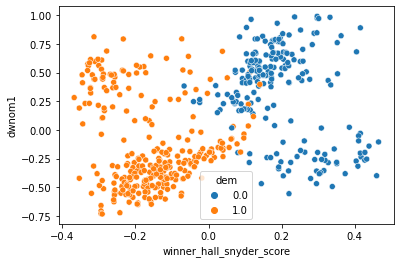

In [4]:
sns.scatterplot(x='winner_hall_snyder_score', y='dwnom1', data=full, hue=full['dem'])

Hmm, this doesn't seem to match Figure 1 from the paper. If you give squint we can start to get a sense of why: it looks like there is a band of dots that following the positive correlation from the figure in the paper, but then another band of dots that have a negative correlation. The reason why is that we are looking at *primary* elections here, so the winner of the primary may not win the general election and enter office. So, the `winner_hall_snyder_score` correspond to the primary winner, but the `dwnom1` corresponds to the general election winner, who might be a different person. 

To fix this, we need want to only compare the ideology of primary winners who go on to win the general election. This is captured by the `dv_win` variable, which will be a key dependent variable for us later.

**Question 1.1. Create a subset of the `full` dataframe that only includes observations where `dv_win` is equal to 1 called `win`. The redo the scatterplot from above using the `win` dataframe.** 

In [ ]:
# Code for 1.1

This should look like the figure from the paper, albeit with the party marked by color rather than Rs and Ds.

**Question 1.2. The paper also reports that the correlation between these measures is 0.90. Use the `stats.pearsonr` function to check this.**

In [ ]:
# Code for 1.2

The paper restricts the analysis to cases where we can clearly say which candidate was more extreme. There is no obvious way to do this, but the authors decide to only look at races where the difference in estimated ideology of the two leading candidates in the primary was more than the median of this distance. This difference is given by the column `absdist`.

**Question 1.3. Compute the median absolute distance between the leading candidates and save it as `med_dist`.** 

In [7]:
# Code for 1.3
med_dist = np.median(full['absdist'])

Hall also sometimes restricts to cases where the margin of victory for the winner was less than or equal to 20%. Let's create a new version of the data frame to run the subsequent analysis on where both of these conditions are met 

In [8]:
# Subset data to only elections within .2 margin and above median distance
within20 = full[(full['margin'] <= 0.2) & (full['absdist'] > med_dist)]
within20.shape[0]

233

Other analysis look at elections where the margin of victory was less than equal to 5%. 

**Question 1.4. Create a version of the data where the distance between candidates is above the median and the margin is less than or equal to 5%, and call this `within5`.**


In [ ]:
# Code for 1.4

**Question 1.5. What proportion of all observations meet the criteria for the `within20` data frame? For the `within5` data frame? While looking at close elections can be good for making causal claims, what is the other side of this tradeoff which is illustrated by this analysis?**

In [ ]:
# Code for 1.5

*Words for 1.5*

## Part 2. Main results

Two of the key variables we will use in the analysis are:
- `rv` (or "running variable"), which is the margin of the vote for the more extreme candidate minus 50%, and 
- `treat`, which is equal to 1 if the more extreme candidate wins and 0 otherwise.

Recall that it is easiest to interpret the RD regressions if the treatment switches from 0 to 1 when the running variable goes from negative to positive.

**Question 2.1. Make a scatterplot with the running variable on the x axis and the treatment on the y axis. Does what you get make sense in light of the discussion above?**

In [ ]:
# Code for 2.1

*Words for 2.1*

The main outcome we will examine in the paper is the vote share in the general election for the candidate that won the primary. In the dataframe this is called `dv`. 

**Question 2.2. Compute the difference of means for this outcome among those where the extremist nominee won versus not, using the full data set. Why might this not be a good esimate of the causal effect of an extremist winning the primary?**

In [ ]:
# Code for 2.2

*Words for 2.2*

Next let's create a version of Figure 2. The big dots are plotting the average outcome for different "bins" of the running variable. We'll give some code to add those later, but for now the main thing we want to plot is the individual points and the trend line before and after switching to the extremist nominee winning. As in Lab 12, an easy way to do this is to create subsets of the data before the cutoff (here, `rv < 0`) and after the cutoff (`rv > 0`) and then use `sns.regplot` on both sides.

**Question 2.3. Create a subset of the `within20` data where `rv < 0` and call this `within20below`. Then create a subset where `rv > 0` called `within20above`. Then replicate figure 2 using sns.regplot.** 

In [ ]:
# Code for 2.3
within20 = 

To really replicate the figure, we can add the binned averages. The code below creates the x and y axis values for these dots by looping through the bins and computing the average general election vote share.

In [10]:
# Make the binned averages, first the bins to the left
count = 0
bin_size = 0.02
binx_left = np.zeros(len(np.arange(-0.2, 0, bin_size)))
biny_left = np.zeros(len(binx_left))
last = -0.2
for j in np.arange(-0.2, 0, bin_size):
    biny_left[count] = np.mean(within20['dv'][(within20['rv'] >= j-bin_size) & (within20['rv'] < j)])
    binx_left[count] = (j+last)/2
    last = j
    count += 1

# Now the bins on the right
count = 0
bin_size = 0.02
binx_right = np.zeros(len(np.arange(0.02, 0.2, bin_size)))
biny_right = np.zeros(len(binx_right))
last = 0
for j in np.arange(0.02, 0.2, bin_size):
    biny_right[count] = np.mean(full['dv'][(within20['rv'] >= j-bin_size) & (within20['rv'] < j)])
    binx_right[count] = (j+last)/2
    last = j
    count += 1


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

Here is a plot with just the bins

In [ ]:
plt.plot(binx_left, biny_left, 'o', color='black', markersize=10)
plt.plot(binx_right, biny_right, 'o', color='black', markersize=10)

[OPTIONAL] Create a code cell with your graph for question 2.3 and then the plotting of the binned averages above. 

Now let's replicate some of the estimates of the causal effect of nominating an extremist from Table 2. Column 1 indicates a local linear regression with a bandwith of 5. 

**Question 2.4. To replicate this, fit and summarize a regression using the `within5` data with the general election vote share as the dependent variable; and the running variable, treatment variable, and an interaction term between the two as dependent variables. Which coefficient corresponds to the reported -0.12 in the table, and why?** 

In [ ]:
# Code for 2.4

*Words for 2.4*

Column 4 has a similar analysis but the dependent variable isn't the general election vote share but an indicator variable equal to 1 if the nominee won the general election and 0 otherwise. This is given by the `dv_win` variable. 

**Question 2.5. Fit and summarize the regression which replicates this column, and interpret the coefficient which corresponds to the estimate for the causal effect of nominating an extremist.**

In [1]:
# Code for 2.5

*Words for 2.5*

## Part 3. Robustness

Recall that there are several ways that one can estimate causal effects with regression discontinuity, using different standards of a "close" election and different kinds of ways to estimate the trend up to and after the treatment starts. 

One alternative is to just compare the average outcome in elections where the extremist barely won and lost *without* fitting a linear trend on both sides of the discontinuity. In particular, we can just compute the difference of means among the elections with a margin of victory less than 5%.

**Question 3.1. To do this is in a way similar to the previous analysis, recall that if we run a linear regression with a binary indpendent variable, the result is equivalent to a difference of means. So, fit and summarize a regression with the general election vote share as the dependent variable and the extremist winning as the independent variable using the `within5` data frame. How does the estimate of the causal effect of nominating an extremist compare to the estimate from column 1 of table 2?**

In [2]:
# Code for 3.1

*Words for 3.1*

**Question 3.2. Now perform the same analysis with the general election victory variable as the outcome. How does the estimate of the causal effect of nominating an extremist differ from the estimate from column 4 of Table 2?**

In [ ]:
# Code for 3.2

*Words for 3.2*

Another thing we can do is look a a "wider bandwith". 

**Question 3.3. Repeat the analysis of columns 1 and 4 from table 2 using a local linear regression but for elections where the margin was within 20% (i.e., use the `within20` data). How does this affect the estimates of the effect of nominating an extremist?**

In [ ]:
# Code for 3.3

*Words for 3.3*

**Question 3.4. Try another alternative estimate of the causal effect of nominating an extremist on the vote share. For example, you could look at a different bandwith, or add polynomial terms to regression (hint: the running variable squared is `rv2`, and the running variable cubed is `rv3`). How does this affect the result?**

In [ ]:
# Code for 3.4

*Words for 3.4*

## Part 4. Other Exploration

The data frame also contains some other interesting variables which are used in other parts of the paper. For example:
- `dem` is 1 if the primary is in the Democratic party and 0 for Republicans.
- `safe_for_party` is whether this is considered a safe district for the party in question
- `dwnom1` is the ideology of the general election winner
- `year` is the year of the election
- `winner_female` is whether the general election winner was female

**Question 4.1. Conduct some analysis using one of these variables (or another new variable in the data frame which you can figure out the meaning of). You can make graphs, run regressions, whatever! Interpret what you find.** 

In [3]:
# Code for 4.1

*Words for 4.1

## Part 5. Wrapping up

**Question 5.1. What did you learn from this replication exercise? (3-4 sentences)**

*Words for 5.1*

**Question 5.2.  What additional data might you want to collect to build on the findings here? What would you expect to find? (4-5 sentences)**

*Words for 5.2*